In [104]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, HDBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

In [14]:
# Preprocess Customers data
def preprocess_customers(customers):
    customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
    customers['DaysSinceSignup'] = (pd.Timestamp.now() - customers['SignupDate']).dt.days
    
    # One-hot encode Region
    region_encoded = pd.get_dummies(customers['Region'], prefix='Region')
    
    # Combine processed features
    processed_customers = pd.concat([customers[['CustomerID', 'DaysSinceSignup']], region_encoded], axis=1)
    processed_customers.set_index('CustomerID', inplace=True)
    return processed_customers

processed_customers = preprocess_customers(customers)

# Aggregate Transactions data
def preprocess_transactions(transactions, products):
    transactions_products = transactions.merge(products, on='ProductID', how='left')
    customer_product_matrix = transactions_products.pivot_table(
        index='CustomerID', 
        columns='Category', 
        values='Quantity', 
        aggfunc='sum', 
        fill_value=0
    )
    return customer_product_matrix

In [15]:
processed_transactions = preprocess_transactions(transactions, products)

# Merge Customers and Transactions data
combined_data = processed_transactions.merge(processed_customers, 
                                             left_index=True, right_index=True, how='inner')

In [16]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_data)

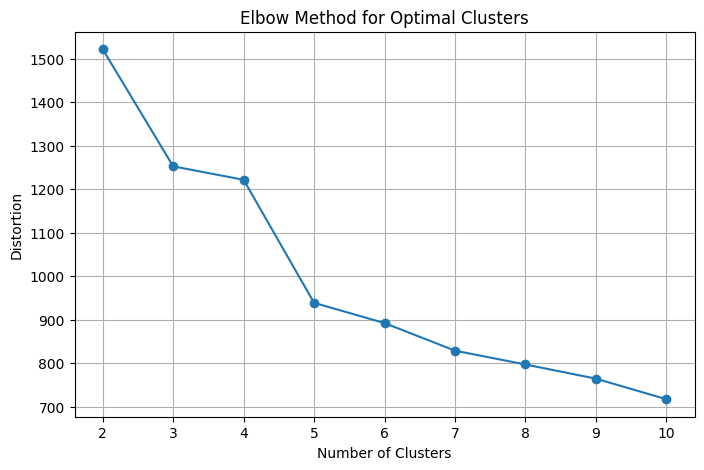

In [17]:
# Function to find the optimal number of clusters using the Elbow Method
def find_optimal_clusters(data, max_k=10):
    distortions = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 5))
    plt.plot(range(2, max_k + 1), distortions, marker='o')
    plt.title('Elbow Method for Optimal Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.grid(True)
    plt.show()

find_optimal_clusters(scaled_data)

In [116]:
# Perform clustering with the chosen number of clusters
num_clusters = 5  # Adjust based on the Elbow Method
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(scaled_data)
labels = kmeans.labels_

# Add labels to data
combined_data['Cluster'] = labels

In [117]:
db_index = davies_bouldin_score(scaled_data, labels)
sil_score = silhouette_score(scaled_data, labels)
print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {sil_score}")

Davies-Bouldin Index: 1.3446211661953789
Silhouette Score: 0.3010923019179308


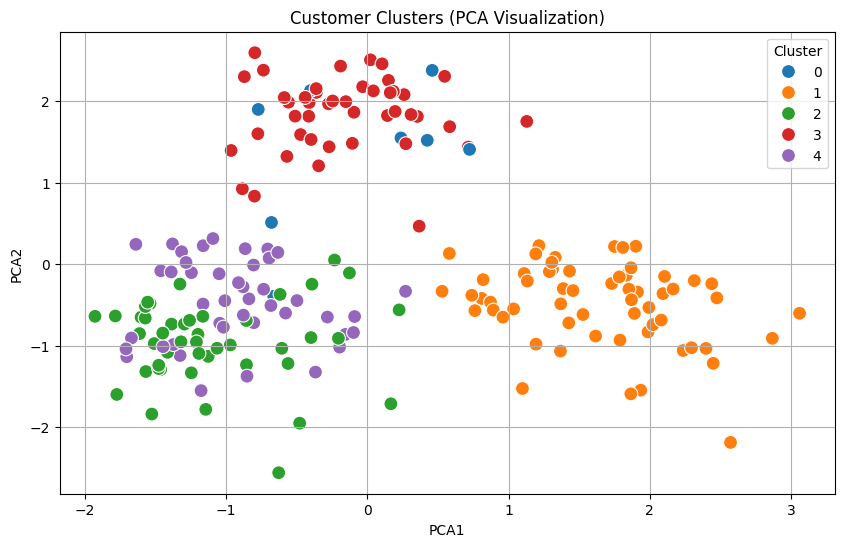

In [118]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=pca_data, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = labels

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=100)
plt.title('Customer Clusters (PCA Visualization)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


## Using HDBSCAN

Davies-Bouldin Index: 1.0923568762237004
Silhouette Score: 0.40026106801238237


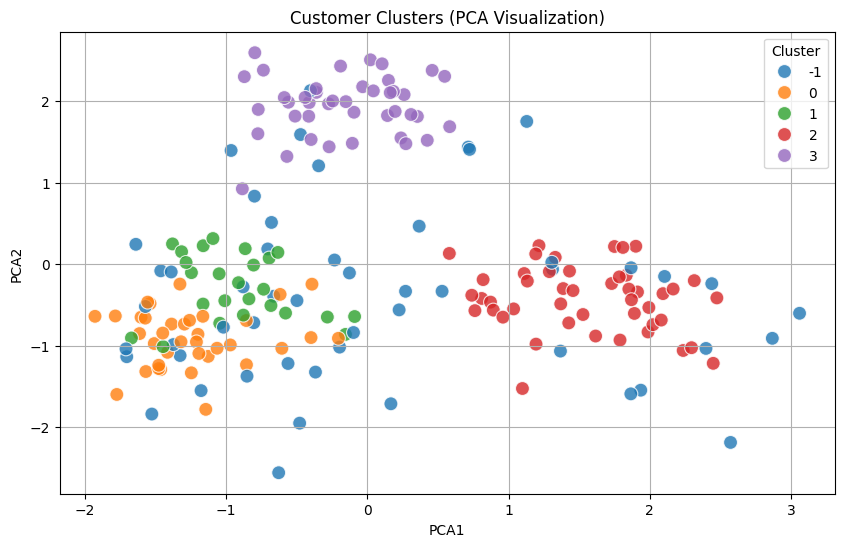

In [119]:
hdbscan = HDBSCAN(min_cluster_size = 25)
labels = hdbscan.fit_predict(scaled_data)

# Add labels to data
combined_data['Cluster'] = labels

# Evaluate clustering using Davies-Bouldin Index and Silhouette Score
# Exclude noise points (-1 label) from evaluation
filtered_data = scaled_data[labels != -1]
filtered_labels = labels[labels != -1]
if len(np.unique(filtered_labels)) > 1:
    db_index = davies_bouldin_score(filtered_data, filtered_labels)
    sil_score = silhouette_score(filtered_data, filtered_labels)
    print(f"Davies-Bouldin Index: {db_index}")
    print(f"Silhouette Score: {sil_score}")
else:
    print("Insufficient clusters for meaningful evaluation.")

# Visualize clusters using PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=pca_data, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = labels

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=100, alpha=0.8)
plt.title('Customer Clusters (PCA Visualization)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [120]:
db_index

1.0923568762237004

In [121]:
sil_score

0.40026106801238237